In [787]:
import copy
import math
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict

In [196]:
def get_k_furthest_nodes(graph, node_list, start_node,k):
    # Create a subgraph with the given node list
    
    subgraph = graph.subgraph(node_list).copy()
    
    # Ensure the start_node is in the subgraph
    if start_node not in subgraph:
        raise ValueError("Start node is not in the subgraph")
    
    # Calculate shortest path lengths from the start node to all other nodes
    path_lengths = nx.single_source_shortest_path_length(subgraph, start_node)
    
    # Sort nodes by their distance from the start node (furthest first)
    sorted_nodes = sorted(path_lengths.items(), key=lambda x: x[1], reverse=True)
    
    # Get the three furthest nodes
    furthest_nodes = [node for node, distance in sorted_nodes[:k]]
    
    return  furthest_nodes

In [867]:

def shortest_path_dynamic(G1,G2, start, end,sensor_mapping,sensor_edge_mapping ,distance_func,weights):
    node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(G1)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    entry=copy.copy(start)
    target_id=copy.copy(end)
    
    subgraph=G1.copy()
    for node in targets:
        if node != end:
            subgraph.remove_node(node)
    G=subgraph.copy()
    subgraph2=G2.copy()
    to_be_removed=[]
    to_be_removed_sensors=[]
    for sensor in list(subgraph2.nodes):
        if max_target_per_sensor[sensor] == end:
            to_be_removed_sensors.append(sensor)
    for node in list(subgraph.nodes):
        if (node != entry and max_target_per_node[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    distances = defaultdict(lambda: float('inf'))
    predecessors = {}
    distances[end] = 0
    queue = [end]
    
    while queue:
        current = queue.pop(0)
        
        for neighbor in G.neighbors(current):
            edge_distance = distance_func(G, current, neighbor,to_be_removed,to_be_removed_sensors,sensor_edge_mapping,weights)
            new_distance = distances[current] + edge_distance
            
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current
                queue.append(neighbor)
    
    # Reconstruct the path
    path = []
    current = start
    while current != end:
        path.append(current)
        if current not in predecessors:
            return float('inf'), None  # No path exists
        current = predecessors[current]
    path.append(end)
    
    return distances[start], path,node_probabilities

def custom_distance(G, node1, node2,excluded_nodes,excluded_sensors,sensor_edge_mapping,weights):
    norm=sum(weights)
    decep_phys=0
    if node2  in excluded_nodes:
        decep_phys=100
    extra_node_cost=2
    share_decep_sensor=100
    covering_sensors=set()
    for sensor,mapping in sensor_edge_mapping.items():
        if (node1,node2) in mapping or (node2,node1) in mapping:
            covering_sensors.add(sensor)
    if any([True for sensor in covering_sensors if sensor not in excluded_sensors]):
        share_decep_sensor=0    
   
    base_weight = G[node1][node2].get('weight', 1)
    return (base_weight*(norm/weights[0])) + ((norm/weights[1])*extra_node_cost)+ ((norm/weights[2])*decep_phys) + ((norm/weights[3])*share_decep_sensor)

In [197]:
import heapq

def min_cost_path(graph, node_costs, start, end, node_weight=1, hop_weight=1):
    # Priority queue to store (cumulative_cost, current_node, hop_count)
    priority_queue = [(node_weight * node_costs[start], start, 0)]
    # Dictionary to track the minimum cost to reach each node
    min_cost = {node: float('inf') for node in graph}
    min_cost[start] = node_weight * node_costs[start]
    # Dictionary to reconstruct the path
    previous_node = {start: None}
    
    while priority_queue:
        current_cost, current_node, hop_count = heapq.heappop(priority_queue)

        # If we reached the end node
        if current_node == end:
            break

        # Explore neighbors
        for neighbor in graph[current_node]:
            new_hop_count = hop_count + 1
            new_cost = current_cost + (node_weight * node_costs[neighbor]) + (hop_weight * new_hop_count)

            # If the new calculated cost is lower, update it
            if new_cost < min_cost[neighbor]:
                min_cost[neighbor] = new_cost
                previous_node[neighbor] = current_node
                heapq.heappush(priority_queue, (new_cost, neighbor, new_hop_count))

    # Reconstruct the path
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = previous_node[current]
    path.reverse()

    return min_cost[end], path


In [198]:
def shortest_path_between_contracted_sets(graph, set1, set2):
    # Create a copy of the graph to modify
    G = graph.copy()
    
    # Contract set1 and set2 into super nodes
    set1=sorted(set1)
    #print(set1)
    if len(set1)>1:
        for node in set1[1:]:
            G2= nx.contracted_nodes(G, set1[0], node,copy=True)
            
    set2=sorted(set2)
    if len(set2)>1:
        for node in set2[1:]:
            G2= nx.contracted_nodes(G, set2[0], node,copy=True)
    if len(set1)+len(set2)>2:   
        if G2.has_edge(set1[0],set2[0]):
            G2.remove_edge(set1[0], set2[0])
    else:
        G2=G.copy()
    # Find the shortest path between super nodes
    try:
        path = nx.shortest_path(G2, set1[0], set2[0])
        
        # Replace super nodes with actual nodes from the sets
        begin=path[1]
        end=path[-1]
        shortest_path_beg = min((nx.shortest_path(G, source=node, target=begin) for node in set1), key=lambda path: nx.path_weight(G, path, weight='weight'))
        shortest_path_end = min((nx.shortest_path(G, source=node, target=end) for node in set2), key=lambda path: nx.path_weight(G, path, weight='weight'))
        fin_path=[]
        fin_path.extend(shortest_path_beg)
        fin_path.extend(path[2:])
        fin_path[-1]=shortest_path_end[-1]
        return fin_path
    except nx.NetworkXNoPath:
        return None

In [199]:
def shortest_path_between_contracted_sets_with_mapping(graph, set1, set2,target_id,max_probabilities,targets,path_main):
    # Create a copy of the graph to modify
    G = graph.copy()
    G2=G.copy()
    entry=0
    to_be_removed=[]

   
    max_prob_target=max_probabilities
    '''for node in subgraph.nodes():
        max_prob_target[node] = max(node_probabilities[node].items(), key=lambda x: x[1])
'''
    #print(max_prob_target)
    #print(target[0])
   
    # Contract set1 and set2 into super nodes
    set1=sorted(set1)
    #print(set1)
    for node in set1[1:]:
        G2= nx.contracted_nodes(G2, set1[0], node,copy=True)
        
    set2=sorted(set2)
    for node in set2[1:]:
        G2= nx.contracted_nodes(G2, set2[0], node,copy=True)
    
    if G2.has_edge(set1[0],set2[0]):
        G2.remove_edge(set1[0], set2[0])
        
        
    #remove truthful nodes
    for node in list(G2.nodes):
        if (node != entry and max_prob_target[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    #print(G2.nodes)

    for node in to_be_removed:
        if nx.has_path(G2, set1[0], set2[0]):
            dummy_sub=G2.copy()
            dummy_sub.remove_node(node)
            if nx.has_path(dummy_sub,set1[0],set2[0]):
                G2.remove_node(node)
    #print(G2.nodes)
    # Find the shortest path between super nodes
    try:
        path = nx.shortest_path(G2, set1[0], set2[0])
        
        # Replace super nodes with actual nodes from the sets
        begin=path[1]
        end=path[-1]
        shortest_path_beg = min((nx.shortest_path(G, source=node, target=begin) for node in set(set1).intersection(set(path_main))), key=lambda path: nx.path_weight(G, path, weight='weight'))
        shortest_path_end = min((nx.shortest_path(G, source=end, target=node) for node in set(set2).intersection(set(path_main))), key=lambda path: nx.path_weight(G, path, weight='weight'))
        fin_path=[]
        fin_path.extend(shortest_path_beg)
        fin_path.extend(path[2:-1])
        fin_path.extend(shortest_path_end)
        return fin_path
    except nx.NetworkXNoPath:
        return None

In [200]:
def union_intersect(dict_of_sets, keys, other_set):
    """
    Perform the union of sets from a dictionary based on given keys,
    then intersect the result with another set.

    Args:
    dict_of_sets (dict): A dictionary where values are sets.
    keys (list): A list of keys to select sets from the dictionary.
    other_set (set): Another set to intersect with the union result.

    Returns:
    set: The intersection of the union of selected sets with other_set.
    """
    # Select sets from the dictionary based on the given keys
    selected_sets = [dict_of_sets[k] for k in keys if k in dict_of_sets]
    
    # If no sets were selected, return an empty set
    if not selected_sets:
        return set()
    
    s = set()
    
    for item in other_set:
        s.add(item)
    
    # Perform the union of the selected sets
    union_result = set.union(*selected_sets)
    
    # Intersect the union result with the other set
    final_result = list(union_result.intersection(s))
    
    return union_result


In [201]:
def rank_nodes(subgraph, G2,t2,node_probabilities,entry,ldp):
    cross_prob_dict={}
    for node in subgraph.nodes:
        if node != entry:
            cross_prob_dict[node]={}
            for target in G2.graph['Targets']:
                cross_prob_dict[node][target]=sum([v * subgraph.graph['Target Probabilities'][k][target]\
                                                   for k,v in node_probabilities[node].items()])
    #print('Cros Prob',cross_prob_dict)
    return sorted(cross_prob_dict.items(), key=lambda x: x[1][t2], reverse=True)

In [202]:
def get_node_probabilities(G1):
    
    subgraph=G1.copy()
    node_probabilities={}
    costs={}
    max_prob_target = {}
    targets=[]
    for node in subgraph.nodes(data=True):
        if node[1].get('type')== 'target':
            targets.append(node[0])
    #print(targets)
    for node in subgraph.nodes:
        if node in targets:
            node_probabilities[node] = {node:1}
            max_prob_target[node]=(node,1)
        else:
            costs[node] = {target: nx.dijkstra_path_length(subgraph,node,target,weight='weight') for target in targets}
            #print(costs[node])
            total_cost = sum([1/costs[node][k] for k,v in costs[node].items()])
            #print(total_cost)
            node_probabilities[node] = {target: (1/cost) / total_cost for target, cost in costs[node].items()}
            #print(node_probabilities[node].items())
            #print(max(node_probabilities[node].items(), key=lambda x: x[1]))
            max_prob_target[node] = max(node_probabilities[node].items(), key=lambda x: x[1])
    return node_probabilities, max_prob_target,targets,costs

In [203]:
def calculate_sensor_probabilities(node_probabilities, sensor_mapping,all_targets):
    sensor_probabilities = {}
    max_target_per_sensor = {}

    for sensor_id, nodes in sensor_mapping.items():
        # Initialize a dictionary to store cumulative probabilities for each target
        target_probabilities = {target: 0 for target in all_targets}

        for node in nodes:
            if node in node_probabilities:
                for target, probability in node_probabilities[node].items():
                    '''for all_target in all_targets:
                        if all_target not in target_probabilities:
                            target_probabilities[target] = 0'''
                    target_probabilities[target] += probability

        # Normalize the probabilities so they sum to 1
        total_probability = sum(target_probabilities.values())
        if total_probability > 0:
            for target in target_probabilities:
                target_probabilities[target] /= total_probability

        # Store the cumulative probabilities for the sensor
        sensor_probabilities[sensor_id] = target_probabilities

        # Determine the target with the maximum probability for this sensor
        if target_probabilities:
            max_target = max(target_probabilities, key=target_probabilities.get)
            max_target_per_sensor[sensor_id] = max_target

    return sensor_probabilities, max_target_per_sensor


In [204]:
def farthest_nodes(graph, entry_node, num_targets):
    # Step 1: Calculate distances from the entry node to all other nodes
    distances = nx.single_source_shortest_path_length(graph, entry_node)
    
    # Step 2: Sort nodes by distance from entry node (farthest first)
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1], reverse=True)
    farthest_candidates = [node for node, dist in sorted_nodes]
    
    # Step 3: Select target nodes that are also far from each other
    selected_targets = []
    
    min_dist = nx.diameter(graph)
    while len(selected_targets) < num_targets+1:
        for candidate in farthest_candidates:
            # Check if the candidate is far enough from the already selected targets
            if all(nx.shortest_path_length(graph, candidate, target) >= min_dist for target in selected_targets):
                selected_targets.append(candidate)
        min_dist-=1
    if 0 in selected_targets:
        selected_targets.remove(0)
    return selected_targets

In [577]:
def create_physical_graph(n, p, num_targets,min_weight,max_weight):
    edges = combinations(range(n), 2)
    G = nx.path_graph(n)
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        G= nx.complete_graph(n, create_using=G)
        for u, v in G.edges():
        
            #G[u][v]['capacity'] = random.randint(-10,-1)
            G[u][v]['weight'] = random.uniform(min_weight,max_weight)
        return G
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    #G=nx.barabasi_albert_graph(n,int(p*10))
    for u, v in G.edges():
        
            #G[u][v]['capacity'] = random.randint(-10,-1)
            G[u][v]['weight'] = float("{:.2f}".format(abs((u) - (v) )*random.uniform(min_weight,max_weight)))
    G.nodes[0]['type'] = 'entry'
    target_nodes=farthest_nodes(G,0,num_targets)[:num_targets]
    for t in target_nodes:
        G.nodes[t]['type'] = 'target'
    return G,target_nodes

In [206]:
def find_sensors(d, set1, set2):
    return [k for k, v in d.items() if set1 in v and set2 in v]

In [207]:
def filter_dict(d, allowed_list):
    return {k: v for k, v in d.items() if any(x not in [y for i, w in d.items() if i != k for y in w] and x in allowed_list for x in v)}

In [658]:
def get_nodes_within_distance(start_node, max_distance,graph,max_nodes_per_sensor):
    distances = nx.single_source_dijkstra_path_length(graph, start_node, cutoff=max_distance, weight='weight')
    #print(distances)
    
    return set(list(distances.keys())[:max_nodes_per_sensor])
def create_coverage_mapping(Gp, num_sensors, sensor_radius,inter_param,max_nodes_per_sensor):
    all_covered_nodes = set()
    init_rad=sensor_radius
    i=1
    while set(all_covered_nodes) != set(Gp.nodes()):
        all_covered_nodes = set()
        C = {v: set() for v in Gp.nodes()}
        S = {s: set() for s in range(num_sensors)}
        senseo_edge_mapping={s: set() for s in range(num_sensors)}
        graph=Gp.copy()
        available_nodes = set(graph.nodes())
        to_keep=[random.choice(list(available_nodes))]
        centers=set()
        for sensor in range(num_sensors):
                     
           # print('Available',available_nodes)
            if not available_nodes:
                graph=Gp.copy()
                available_nodes=set([node for node in graph.nodes() if node not in centers])
                to_keep=available_nodes
                graph.remove_nodes_from(centers)
            start_node = random.choice(list(to_keep))
            centers.add(start_node)
            #print(graph.nodes())
            covered_nodes = get_nodes_within_distance(start_node, sensor_radius,graph,max_nodes_per_sensor)

                
            to_keep=get_k_furthest_nodes(graph,covered_nodes,start_node,inter_param)
            to_remove=[]
            for node in graph.nodes():
                if node in covered_nodes:
                    all_covered_nodes.add(node)
                    if node not in to_keep:
                        to_remove.append(node)
            
            S[sensor] = covered_nodes
            for node in covered_nodes:
                C[node].add(sensor)
            available_nodes -= covered_nodes
            graph.remove_nodes_from(to_remove)
            sing_cent=random.choice(list(to_keep))
            new_centers=sing_cent
            #get_nodes_within_distance(sing_cent, sensor_radius*0.7,graph,max_nodes_per_sensor)
            new_centers=[sing_cent]
                #get_k_furthest_nodes(graph,new_centers,sing_cent,inter_param))
            to_keep=new_centers
        #print(all_covered_nodes)
        
        if set(all_covered_nodes) != set(Gp.nodes()):
            sensor_radius+= 1
            i+=1
            if i >=10 :
                num_sensors+=1
                i=1
                #print(num_sensors)
            
        '''for sensor in range(num_sensors):
            if not S[sensor]:
                start_node = random.choice(list(Gp.nodes()))
                covered_nodes = get_nodes_within_distance(start_node, sensor_radius)
                S[sensor] = covered_nodes
                for node in covered_nodes:
                    C[node].add(sensor)'''
    print('Radius',sensor_radius)
    #S = {k: v for k, v in S.items() if len(v) > 1}
    C = {k: {item for item in v if item in S.keys()} for k, v in C.items()}
    print('Number of sensors',len(S.keys()))
    
    senseo_edge_mapping={s: set() for s in range(num_sensors)}
    for s in S.keys():
        hold=set()
        for (j,k) in Gp.edges():
            #print((j,k))
            if (j in S[s]) and (k in S[s]):
                hold.add((j,k))
        #print(hold,s)
        senseo_edge_mapping[s]=hold
    
    edges_to_remove=[]
    for (u,v) in Gp.edges():
        covered=False
        for key,val in senseo_edge_mapping.items():
            if (u,v) in val  or (v,u):
                covered=True
                break
        if not covered:
            edges_to_remove.append((u,v))
    
    for e in edges_to_remove:
        Gp.remove_edge(e[0],e[1])
        Gp.remove_edge(e[1],e[0])
                
    return C, S,senseo_edge_mapping
def create_sensor_graph(S):
    Gs = nx.Graph()
    Gs.add_nodes_from(S.keys())
    for s1 in S:
        for s2 in S:
            if s1 != s2:
                if S[s1].intersection(S[s2]) and not Gs.has_edge(s2,s1):
                    Gs.add_edge(s1, s2)
    return Gs
def draw_graphs(Gp, Gs, C, S, pos):
    plt.figure(figsize=(22, 15))
    
    # Draw physical graph
    plt.subplot(121)
    edges = Gp.edges()
    weights = [Gp[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(Gp, pos, alpha=0.2, width=1.5)
    
    for node, sensors in C.items():
        if len(sensors) > 0:
            colors = [f'C{s}' for s in sensors]
            size = 300 if Gp.nodes[node].get('type') in ['entry', 'target'] else 200
            plt.pie([1]*len(sensors), colors=colors, center=pos[node], radius=size/plt.gcf().dpi*0.02)
    
    nx.draw_networkx_labels(Gp, pos, font_size=8, font_weight='bold')
    
    edge_labels = nx.get_edge_attributes(Gp, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels,font_size=8)
    
    plt.title("Physical Graph with Sensor Coverage")
    plt.axis('equal')
    
    # Draw sensor graph
    plt.subplot(122)
    pos_s = nx.spring_layout(Gs)
    nx.draw(Gs, pos_s, with_labels=True, node_color='lightgreen', node_size=500, font_size=10, font_weight='bold')
    plt.title("Sensor Graph")
    
    plt.tight_layout()
    plt.show()

In [806]:
def evaluate_path_and_sensor(G1,weight_path,path,number_sensors,diameter_physical,available_sensors,truthful_physical,truthful_sensor, weights):
    path_metric=0
    sensor_metric=0
    norm_factor=sum(weights)
    weights_final=[(w/norm_factor) for w in weights]
    path_metric=((weight_path/diameter_physical) + (len(path)/len(G1.nodes())))/2
    
    sensor_metric=number_sensors/available_sensors
    
    
    path_score=(weights_final[0]*(path_metric*diameter_physical)) +(weights_final[1]*sensor_metric) + (weights_final[2]*(truthful_physical*len(path))) + (weights_final[3]*(number_of_sensors*truthful_sensor))
    
    return path_score
    

In [209]:
def rank_nodes_by_distance(graph, start, nodes):
    distances = nx.single_source_dijkstra_path_length(graph, start)
    return sorted(nodes, key=lambda node: distances.get(node, float('inf')), reverse=True)

In [210]:
def rank_nodes_by_distance_multiple(graph, start_nodes, nodes_to_rank):
    # Compute distances from all start nodes to all other nodes
    distances = {}
    for start in start_nodes:
        distances[start] = nx.single_source_dijkstra_path_length(graph, start)
    
    # Function to get the minimum distance from any start node to a given node
    def min_distance(node):
        return min(distances[start].get(node, float('inf')) for start in start_nodes)
    
    # Sort nodes based on their minimum distance to any start node
    return sorted(nodes_to_rank, key=min_distance, reverse=True)

In [713]:
def best_sensor_path_strategy(G1, G2, e1, sensor_mapping,sensor_edge_mapping,target_id,node_mapping):
    node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(G1)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    
    subgraph2=G2.copy()
    to_be_removed_sensors=[]
    for sensor in list(subgraph2.nodes):
        if max_target_per_sensor[sensor] == target_id:
            to_be_removed_sensors.append(sensor)
    entry_sensors=set()
    target_sensors=set()

    for sensor in node_mapping[e1]:
        entry_sensors.add(sensor)
    for sensor in node_mapping[target_id]:
        target_sensors.add(sensor)
    initial_entry=copy.deepcopy(entry_sensors)
    initial_targets=copy.deepcopy(target_sensors)
    to_be_removed_sensors=rank_nodes_by_distance_multiple(G2,target_sensors,to_be_removed_sensors)
    for sensor in to_be_removed_sensors:
        if any(nx.has_path(subgraph2, source, target) for source in entry_sensors for target in target_sensors):
            dummy_sub=subgraph2.copy()
            dummy_sub.remove_node(sensor)
            #print('Sensor removed',sensor)
            if sensor in target_sensors:
                target_sensors.remove(sensor)
            if sensor in entry_sensors:
                entry_sensors.remove(sensor)
            if any(nx.has_path(dummy_sub, source, target) for source in entry_sensors for target in target_sensors):
                subgraph2.remove_node(sensor)
                #print('Sensor removed',sensor)
                if sensor in target_sensors:
                    target_sensors.remove(sensor)
                if sensor in entry_sensors:
                    entry_sensors.remove(sensor)
            else:
                if sensor in node_mapping[e1]:
                    entry_sensors.add(sensor)
                elif sensor in node_mapping[target_id]:
                    target_sensors.add(sensor)
    path=min((nx.shortest_path(subgraph2, source, target) for source in entry_sensors for target in target_sensors if nx.has_path(subgraph2, source, target)), key=len, default=None)
    if not path:
        path=[list(initial_entry.intersection(initial_targets))[0]]
    print(path)
    considered_edges=set()
    
    for sensor in path:
        for edge in sensor_edge_mapping[sensor]:
            considered_edges.add(edge)
    print(considered_edges)
    node_subgraph= nx.Graph()
    node_subgraph.add_edges_from(considered_edges)
    #nx.draw(node_subgraph, with_labels=True, font_weight='bold')
    #print('Node subgraph',node_subgraph)
    min_cost=float('inf')
    to_be_removed=[]
    temp_ldp=None
    ldp=None
    for node in node_subgraph.nodes():
        if (node != e1 and max_target_per_node[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    #print(to_be_removed)
    to_be_removed= rank_nodes_by_distance(node_subgraph,target_id,to_be_removed)
    '''non_deceptive_ldp=None
    for node in node_subgraph.nodes():
        if node not in to_be_removed:
            #print(target[0])
            #print(costs[node].get(target[0]))
            if costs[node].get(target_id) < min_cost:
                min_cost = costs[node].get(target_id)
                temp_ldp = node
               # print('Current temp ldp:',temp_ldp)
        else:
            if node not in targets:
                if costs[node].get(target_id) < min_cost:
                    min_cost = costs[node].get(target_id)
                    non_deceptive_ldp = node
                    #print('Current non deceptive ldp:',temp_ldp)
    if not temp_ldp:
        temp_ldp=non_deceptive_ldp
        print('LDP is NOT DECEPTIVE')'''
    #print('Temp',temp_ldp)
    #print('Neighbors',list(subgraph.neighbors(temp_ldp)))
    '''min_cost=float('inf')
    if target_id not in node_subgraph.neighbors(temp_ldp):
        for node in node_subgraph.neighbors(temp_ldp):
            if node not in targets:
                if costs[node].get(target_id) < min_cost:
                    min_cost = costs[node].get(target_id)
                    ldp = node
                    if ldp in to_be_removed:
                        to_be_removed.remove(ldp)
    else:
        ldp= temp_ldp
        if ldp in to_be_removed:
            to_be_removed.remove(ldp)'''
    #print(ldp)
    
    for node in to_be_removed:
        if (node != e1 and  node != target_id) and nx.has_path(node_subgraph, e1, target_id):
            dummy_sub=node_subgraph.copy()
            dummy_sub.remove_node(node)
            if nx.has_path(dummy_sub,e1,target_id):
                node_subgraph.remove_node(node)


    # Calculate the shortest path from entry to LDP
    node_path = nx.shortest_path(node_subgraph, source=e1, target=target_id, weight='weight')
    print(node_path)
    #fin_g=node_subgraph.copy()
    #fin_g.remove_nodes_from(node_path[:-1])
    #node_path2 = nx.shortest_path(fin_g, source=node_path[-1], target=target_id, weight='weight')
    #print(node_path)
    path_weight=nx.path_weight(G1,node_path,weight='weight')
    #weight_left=nx.path_weight(G1,node_path2,weight='weight')
    complete_path=[]
    #complete_path.extend(node_path[:-1])
    #complete_path.extend(node_path2)
    complete_path=node_path
    truthful_step=0
    for node in complete_path[:-1]:
        if node in to_be_removed:
            truthful_step+=1
    truthful_sensors=0
    for sensor in path:
        if sensor in to_be_removed_sensors:
            truthful_sensors+=1
    path_weight=path_weight#+weight_left
    number_of_sensors=len(path)
    physical_diameter=nx.diameter(G1,weight='weight')
    sensor_diameter=nx.diameter(G2,weight='weight')
    path_truthfulness=(truthful_step/len(complete_path[:-1]))
    sensor_truthfulness=(truthful_sensors/number_of_sensors)
    print('returned')
    '''print('Sensor path:',path)
    print('Number of non-deceptive sensors:',truthful_sensors,'Non deceptive sensors:',set(to_be_removed_sensors).intersection(set(path)), 'Number of sensors:',number_of_sensors)
    print('Sensor deceptiveness:', 1 -(truthful_sensors/len(path)))
    print('Number of non_deceptive steps',truthful_step,'Truthful steps:',set(to_be_removed).intersection(set(complete_path))) 
    print('Path weight:',path_weight)
    print('Path deceptiveness:', 1 - (truthful_step/len(complete_path)))'''
    return path_weight,number_of_sensors,physical_diameter,sensor_diameter,path_truthfulness,sensor_truthfulness,complete_path,path

In [212]:
def best_sensor_path_strategy_no_ldp(G1, G2, e1, sensor_mapping,target_id,node_mapping):
    node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(G1)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    
    subgraph=G2.copy()
    to_be_removed_sensors=[]
    for sensor in list(subgraph.nodes):
        if max_target_per_sensor[sensor] == target_id:
            to_be_removed_sensors.append(sensor)
    entry_sensors=set()
    target_sensors=set()
    
    for sensor in node_mapping[e1]:
        entry_sensors.add(sensor)
    for sensor in node_mapping[target_id]:
        target_sensors.add(sensor)
    to_be_removed_sensors=rank_nodes_by_distance_multiple(G2,target_sensors,to_be_removed_sensors)
    for sensor in to_be_removed_sensors:
        if any(nx.has_path(subgraph, source, target) for source in entry_sensors for target in target_sensors):
            dummy_sub=subgraph.copy()
            dummy_sub.remove_node(sensor)
            #print('Sensor removed',sensor)
            if sensor in target_sensors:
                target_sensors.remove(sensor)
            if sensor in entry_sensors:
                entry_sensors.remove(sensor)
            if any(nx.has_path(dummy_sub, source, target) for source in entry_sensors for target in target_sensors):
                subgraph.remove_node(sensor)
                #print('Sensor removed',sensor)
                if sensor in target_sensors:
                    target_sensors.remove(sensor)
                if sensor in entry_sensors:
                    entry_sensors.remove(sensor)
            else:
                if sensor in node_mapping[e1]:
                    entry_sensors.add(sensor)
                elif sensor in node_mapping[target_id]:
                    target_sensors.add(sensor)
    path=min((nx.shortest_path(subgraph, source, target) for source in entry_sensors for target in target_sensors if nx.has_path(subgraph, source, target)), key=len, default=None)
    
    considered_nodes=set()
    for sensor in path:
        for node in sensor_mapping[sensor]:
            considered_nodes.add(node)
    #print(considered_nodes)
    node_subgraph= nx.subgraph(G1,considered_nodes).copy()
    #print('Node subgraph',node_subgraph)
    to_be_removed=[]
    for node in list(node_subgraph.nodes):
        if (node != e1 and max_target_per_node[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    #print(to_be_removed)
    to_be_removed= rank_nodes_by_distance(G1,target_id,to_be_removed)
    #print('Temp',temp_ldp)
    #print('Neighbors',list(subgraph.neighbors(temp_ldp)))
   
    
    for node in to_be_removed:
        if node != e1 and nx.has_path(node_subgraph, e1, target_id):
            dummy_sub=node_subgraph.copy()
            dummy_sub.remove_node(node)
            if nx.has_path(dummy_sub,e1,target_id):
                node_subgraph.remove_node(node)


    # Calculate the shortest path from entry to LDP
    node_path = nx.shortest_path(node_subgraph, source=e1, target=ldp, weight='weight')
    fin_g=G1.copy()
    fin_g.remove_nodes_from(node_path[:-1])
    node_path2 = nx.shortest_path(fin_g, source=ldp, target=target_id, weight='weight')
    #print(node_path)
    path_weight=nx.path_weight(G1,node_path,weight='weight')
    weight_left=nx.path_weight(G1,node_path2,weight='weight')
    complete_path=[]
    complete_path.extend(node_path[:-1])
    complete_path.extend(node_path2)
    truthful_step=0
    for node in complete_path:
        if node in to_be_removed:
            truthful_step+=1
    truthful_sensors=0
    for sensor in path:
        if sensor in to_be_removed_sensors:
            truthful_sensors+=1
    print('Sensor path:',path)
    print('Number of non-deceptive sensors:',truthful_sensors,'Non deceptive sensors:',set(to_be_removed_sensors).intersection(set(path)), 'Number of sensors:',len(path))
    print('Sensor deceptiveness:', 1 -(truthful_sensors/len(path)))
    print('Number of non_deceptive steps',truthful_step,'Truthful steps:',set(to_be_removed).intersection(set(complete_path))) 
    print('Path weight:',path_weight+weight_left)
    print('Path deceptiveness:', 1 - (truthful_step/len(complete_path)))

In [213]:
def best_sensors_for_path(path,e1,sensor_edge_mapping,node_probabilities,sensor_mapping,targets,target_id,node_mapping,ldp):
    sensor_path=[]
    sensor_and_coverage=[]
    for u,v in zip(path,path[1:]):
        edge=(u,v)
        available_sensors=set()
        for sensor,edges in sensor_edge_mapping.items():
            if edge in edges or ((v,u) in edges):
                available_sensors.add(sensor)
        available_sensors=list(available_sensors)
        sensor_path.append(available_sensors)
        sensor_and_coverage.append((available_sensors,edge))
    #print('Sensor path:',sensor_and_coverage)
    '''for u,v,id in zip(sensor_path,sensor_path[1:],range(len(sensor_path))):
        common=set(v).intersection(set(u))
        if common:
            hold=[]
            for sensor in u:
                if sensor not in common:
                    hold.append(sensor)
            sensor_path[id]=hold
    '''
            
    sensor_graph=nx.Graph()
    for u,v in zip(sensor_path,sensor_path[1:]):
      #  if not set(u).intersection(v):
            for sensor1 in u:
                for sensor2 in v:
                    if sensor1 != sensor2 :
                        sensor_graph.add_edge(sensor1,sensor2)
    #nx.draw(sensor_graph, with_labels=True, font_weight='bold')                    
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    
    subgraph=sensor_graph.copy()
    to_be_removed_sensors=[]
    for sensor in list(subgraph.nodes):
        if max_target_per_sensor[sensor] == target_id:
            to_be_removed_sensors.append(sensor)
    entry_sensors=set()
    target_sensors=set()
    
    for sensor in node_mapping[e1]:
        if sensor in sensor_graph.nodes():
            entry_sensors.add(sensor)
    for sensor in node_mapping[ldp]:
        if sensor in sensor_graph.nodes():
            target_sensors.add(sensor)
   # nx.draw(sensor_graph, with_labels=True, font_weight='bold')
    if sensor_graph.edges():
        for sensor in to_be_removed_sensors:
            if any(nx.has_path(sensor_graph, source, target) for source in entry_sensors for target in target_sensors):
                dummy_sub=sensor_graph.copy()
                dummy_sub.remove_node(sensor)
                #print('Sensor removed',sensor)
                if sensor in target_sensors:
                    target_sensors.remove(sensor)
                if sensor in entry_sensors:
                    entry_sensors.remove(sensor)
                if any(nx.has_path(dummy_sub, source, target) for source in entry_sensors for target in target_sensors):
                    sensor_graph.remove_node(sensor)
                    #print('Sensor removed',sensor)
                    if sensor in target_sensors:
                        target_sensors.remove(sensor)
                    if sensor in entry_sensors:
                        entry_sensors.remove(sensor)
                else:
                    if sensor in node_mapping[e1]:
                        if sensor in sensor_graph.nodes():
                            entry_sensors.add(sensor)
                    elif sensor in node_mapping[target_id]:
                        if sensor in sensor_graph.nodes():
                            target_sensors.add(sensor)
       # nx.draw(sensor_graph, with_labels=True, font_weight='bold')
       # print('Entry sensors:',entry_sensors)
        #print('Target sensors:',target_sensors)
        fin_sensor_path=min((nx.shortest_path(sensor_graph, source, target) for source in entry_sensors for target in target_sensors if nx.has_path(sensor_graph, source, target)), key=len, default=None)
        #print(fin_sensor_path)
        
        if not fin_sensor_path:
            fin_sensor_path=list(sensor_graph.nodes())[0]
    else:
        fin_sensor_path=[sensor_and_coverage[0][1][0]]
    if not isinstance(fin_sensor_path,list):
        fin_sensor_path=[fin_sensor_path]
    for i in range(len(sensor_and_coverage)):
        new_map=sensor_and_coverage[i][0]
        for sensor in sensor_and_coverage[i][0]:
            if sensor not in fin_sensor_path:
                new_map.remove(sensor)
        sensor_and_coverage[i]=(new_map,sensor_and_coverage[i][1])
            
    return fin_sensor_path,to_be_removed_sensors,sensor_and_coverage

In [256]:
def find_all_paths_multiple(G, start_nodes, end_nodes):
    all_paths = []
    for start_node in start_nodes:
        for end_node in end_nodes:
            paths = nx.all_simple_paths(G, start_node, end_node)
            all_paths.extend(list(paths))
    return all_paths

In [851]:
def all_sensors_for_path(path,G2,e1,sensor_edge_mapping,node_mapping,target_id):
    sensor_path=[]
    for u,v in zip(path,path[1:]):
        edge=(u,v)
        available_sensors=set()
        for sensor,edges in sensor_edge_mapping.items():
            if edge in edges or ((v,u) in edges):
                available_sensors.add(sensor)
        available_sensors=list(available_sensors)
        sensor_path.append(available_sensors)
    #print('Sp',sensor_path)
    sensor_graph=nx.Graph()
    for u,v in zip(sensor_path,sensor_path[1:]):
      #  if not set(u).intersection(v):
            for sensor1 in u:
                for sensor2 in v:
                    if sensor1 != sensor2 :
                        sensor_graph.add_edge(sensor1,sensor2)
    entry_sensors=set()
    target_sensors=set()
    
    for sensor in node_mapping[e1]:
        if sensor in sensor_graph.nodes():
            entry_sensors.add(sensor)
    for sensor in node_mapping[target_id]:
        if sensor in sensor_graph.nodes():
            target_sensors.add(sensor)
    sensors=find_all_paths_multiple(sensor_graph,entry_sensors,target_sensors)
    inter=entry_sensors.intersection(target_sensors)
    add=[]
    if inter:
        for sensor in inter:
            add.append([sensor])
        sensors.extend(add)
    return sensors

In [622]:
def best_physical_path_strategy_no_ldp(G1, e1,G2, sensor_mapping,target_id,sensor_edge_mapping,node_mapping):
    '''    targets=[]
    for node in subgraph.nodes():
        if subgraph[node]['type'] == 'target':
            targets.append(node)'''
    entry=e1
    paths=[]
    subgraph=G1.copy()
    min_cost = float('inf')
    temp_ldp= None
    ldp = None
    to_be_removed=[]

   
    node_probabilities,max_prob_target,targets,costs = get_node_probabilities(subgraph)
    '''for node in subgraph.nodes():
        max_prob_target[node] = max(node_probabilities[node].items(), key=lambda x: x[1])
'''
    #print(max_prob_target)
    #print(target[0])
    for node in list(subgraph.nodes):
        if (node != entry and max_prob_target[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    to_be_removed= rank_nodes_by_distance(subgraph,target_id,to_be_removed)
    for node in to_be_removed:
        if node != entry and node != target_id and nx.has_path(subgraph, entry, target_id):
            dummy_sub=subgraph.copy()
            dummy_sub.remove_node(node)
            if nx.has_path(dummy_sub,entry,target_id):
                subgraph.remove_node(node)


    # Calculate the shortest path from entry to LDP
    path = nx.shortest_path(subgraph, source=entry, target=target_id, weight='weight')
    
    weight_covered=nx.path_weight(G1,path,weight='weight')
    #paths.append(path)
    store1=[]
    store2=[]
    fin_sensor_path,to_be_removed_sensors,sensor_and_coverage=best_sensors_for_path(path,e1, sensor_edge_mapping, node_probabilities, sensor_mapping, targets, target_id,node_mapping,target_id)
    #print(adjusted_mapping)
    #nx.draw(subgraph3, with_labels=True)
    #print(path2)
   
    truthful_sensors=0
    for sensor in to_be_removed_sensors:
        if sensor in fin_sensor_path:
            truthful_sensors+=1         
    number_of_sensors=len(fin_sensor_path)
    physical_diameter=nx.diameter(G1,weight='weight')
    sensor_diameter=nx.diameter(G2,weight='weight')
    sensor_deceptiveness=truthful_sensors/number_of_sensors
    truthful_steps=len(set(to_be_removed).intersection(set(path[:-1])))
    physical_deceptiveness= truthful_steps / (len(path[:-1]))
    
    #adjusted_mapping2 = {k: v for k, v in adjusted_mapping2.items() if len(v) > 1}
    #print('Node path and sensors:',sensor_and_coverage)
    '''print('Sensor path:',fin_sensor_path,'Non deceptive sensors:',truthful_sensors,'Number of sensors:',number_of_sensors)
    print('Sensor deceptiveness:',1-(truthful_sensors/len(fin_sensor_path)))
    
    print('Non deceptive steps/nodes',truthful_steps,set(to_be_removed).intersection(set(path)))
    print('Path weight:',weight_covered)
    
    print('Path deceptiveness',1-physical_deceptiveness)'''
    
    return weight_covered,number_of_sensors,physical_diameter,sensor_diameter,physical_deceptiveness,sensor_deceptiveness,path,fin_sensor_path


In [619]:
def draw_graph_with_sensors(G, sensor_coverage):
    # Create a new figure
    plt.figure(figsize=(12, 8))
    
    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
    
    # Generate a list of distinct colors for sensors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(sensor_coverage)))
    
    # Draw circles for each sensor's coverage
    for (sensor, nodes), color in zip(sensor_coverage.items(), colors):
        # Find the center of the nodes covered by this sensor
        x_mean = sum(pos[node][0] for node in nodes) / len(nodes)
        y_mean = sum(pos[node][1] for node in nodes) / len(nodes)
        
        # Calculate the radius to encompass all nodes
        radius = max(((pos[node][0] - x_mean)**2 + (pos[node][1] - y_mean)**2)**0.5 for node in nodes)
        
        # Draw the circle
        circle = patches.Circle((x_mean, y_mean), radius, fill=False, edgecolor=color, linewidth=2, alpha=0.7)
        plt.gca().add_patch(circle)
        
        # Add a label for the sensor
        plt.text(x_mean, y_mean + radius, f"Sensor {sensor}", color=color, fontsize=8, ha='center', va='bottom')

    plt.title("Graph with Sensor Coverage")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    # Draw the graph with sensor coverage
    

In [779]:
def brute_force_path_strategy(G1,e1,G2,sensor_mapping,sensor_edge_mapping,target_id,node_mapping,weights,debug):
    fin_cost=float('inf')
    to_be_removed=[]
    subgraph=G1.copy()
    node_probabilities,max_prob_target,targets,costs = get_node_probabilities(subgraph)
    for node in targets:
        if node != target_id:
            subgraph.remove_node(node)
    physical_diameter=nx.diameter(G1,weight='weight')
    sensor_diameter=nx.number_of_nodes(G2)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    best_physical=[]
    best_sensor=[]
    subgraph2=G2.copy()
    to_be_removed_sensors=[]
    for sensor in list(subgraph2.nodes):
        if max_target_per_sensor[sensor] == target_id:
            to_be_removed_sensors.append(sensor)
    for node in list(subgraph.nodes):
        if (node != e1 and max_prob_target[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    if subgraph.has_edge(target_id,e1):
        subgraph.remove_edge(e1,target_id)
    paths=nx.all_simple_paths(subgraph,e1,target_id)

    for path in tqdm(paths):
        #if debug:
          #      print('Path on hand',path)
        if 1:
            #if debug:
                #print('No intersections',path)
            path_weight=nx.path_weight(G1,path,weight='weight')
            percent_truthful_node=(len(set(to_be_removed).intersection(set(path[:-1]))))/len(path[:-1])
            sensor_paths=all_sensors_for_path(path,G2,e1,sensor_edge_mapping,node_mapping,target_id)
            #if debug:
                #print('Sensor paths',sensor_paths)
            #print(sensor_paths)
            for sensor_path in sensor_paths:
                number_of_sensors=len(sensor_path)
                number_truthful_sensor=(len(set(to_be_removed_sensors).intersection(set(sensor_path))))
                
                cost=evaluate_path_and_sensor(G1,path_weight,path,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node,number_truthful_sensor_truthful_sensor,weights)
                if debug:
                    print('Candidate path:',path_weight,path,sensor_path,'Path score:',cost)
                if cost<fin_cost:
                    best_physical=path
                    best_sensor=sensor_path
                    fin_cost=cost
                    
                   # if debug:
                      #  print('Best path:',path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node,percent_truthful_sensor,weights)
                    #print('Min cost:',cost)
                
    return fin_cost,best_physical,best_sensor
                
                
                
    

In [612]:
def best_physical_path_strategy_(G1, e1,G2, sensor_mapping,target_id,sensor_edge_mapping,node_mapping):
    '''    targets=[]
    for node in subgraph.nodes():
        if subgraph[node]['type'] == 'target':
            targets.append(node)'''
    entry=e1
    paths=[]
    subgraph=G1.copy()
    min_cost = float('inf')
    temp_ldp= None
    ldp = None
    to_be_removed=[]

   
    node_probabilities,max_prob_target,targets,costs = get_node_probabilities(subgraph)
    '''for node in subgraph.nodes():
        max_prob_target[node] = max(node_probabilities[node].items(), key=lambda x: x[1])
'''
    #print(max_prob_target)
    #print(target[0])
    for node in list(subgraph.nodes):
        if (node != entry and max_prob_target[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    #print(to_be_removed)
    for node in list(subgraph.nodes):
        if node not in to_be_removed:
            #print(target[0])
            #print(costs[node].get(target[0]))
            if costs[node].get(target_id) < min_cost:
                min_cost = costs[node].get(target_id)
                temp_ldp = node
    #print(temp_ldp)
    #print('Neighbors',list(subgraph.neighbors(temp_ldp)))
    min_cost = float('inf')
    if target_id not in subgraph.neighbors(temp_ldp):
        for node in subgraph.neighbors(temp_ldp):
            if node not in targets:
                if costs[node].get(target_id) < min_cost:
                    min_cost = costs[node].get(target_id)
                    ldp = node
                   # if ldp in to_be_removed:
                    #    to_be_removed.remove(ldp)
    else:
        ldp= temp_ldp
       # if ldp in to_be_removed:
         #   to_be_removed.remove(ldp)
    path2=nx.shortest_path(G1, source=ldp, target=target_id, weight='weight')
    to_be_removed= rank_nodes_by_distance(subgraph,target_id,to_be_removed)
    for node in to_be_removed:
        if node != entry and node != ldp and nx.has_path(subgraph, entry, ldp):
            dummy_sub=subgraph.copy()
            dummy_sub.remove_node(node)
            if nx.has_path(dummy_sub,entry,ldp):
                subgraph.remove_node(node)


    # Calculate the shortest path from entry to LDP
    path = nx.shortest_path(subgraph, source=entry, target=ldp, weight='weight')
    fin_g=G1.copy()
    fin_g.remove_nodes_from(path[:-1])
    path2=nx.shortest_path(fin_g, source=ldp, target=target_id, weight='weight')
    weight_left=nx.path_weight(G1,path2,weight='weight')
    weight_covered=nx.path_weight(G1,path,weight='weight')
    #paths.append(path)
    store1=[]
    store2=[]
    #fin_sensor_path,to_be_removed_sensors,sensor_and_coverage=best_sensors_for_path(path,e1, sensor_edge_mapping, node_probabilities, sensor_mapping, targets, target_id,node_mapping,ldp)
    #print(adjusted_mapping)
    #nx.draw(subgraph3, with_labels=True)
    #print(path2)
   
            
        
    #adjusted_mapping2 = {k: v for k, v in adjusted_mapping2.items() if len(v) > 1}
    #print('Node path and sensors:',sensor_and_coverage)
    complete_path=[]
    complete_path.extend(path[:-1])
    complete_path.extend(path2)
    remaining_sensor_path,to_be_removed_sensors2,sensor_and_coverage2=best_sensors_for_path(complete_path,e1, sensor_edge_mapping, node_probabilities, sensor_mapping, targets, target_id,node_mapping,target_id)
    complete_sensor_path=[]
#    complete_sensor_path.extend(fin_sensor_path[:-1])
   # complete_sensor_path.extend(remaining_sensor_path)
    complete_sensor_path=remaining_sensor_path
    truthful_sensors=0
    #for sensor in to_be_removed_sensors2:
     #   if sensor not in to_be_removed_sensors:
      #      to_be_removed_sensors.append(sensor)
    for sensor in to_be_removed_sensors2:
        if sensor in complete_sensor_path:
            truthful_sensors+=1 
    path_weight=weight_covered+weight_left
    number_of_sensors=len(set(complete_sensor_path))
    physical_diameter=nx.diameter(G1,weight='weight')
    sensor_diameter=nx.diameter(G2,weight='weight')
    truthful_steps=len(set(to_be_removed).intersection(set(complete_path[:-1])))
    percent_truthful_sensor=truthful_sensors/number_of_sensors
    deceptiveness= truthful_steps / len(complete_path[:-1])
    '''print('Sensor path:',complete_sensor_path,'Non deceptive sensors:',truthful_sensors,'Number of sensors:',number_of_sensors)
    print('Sensor deceptiveness:',1-(truthful_sensors/len(complete_sensor_path)))
    #print('Work left',path2)
    
    print('Non deceptive steps/nodes',truthful_steps,set(to_be_removed).intersection(set(complete_path)))
    
    print('Path weight:',path_weight)
    #deceptiveness=(len([step for step in path2 if step not in path])+truthful_steps)/(complete_path)
    
    print('Path deceptiveness',1-deceptiveness)'''
    
    #print('Remaining sensors:',remaining_sensor_path)

    return path_weight,number_of_sensors,physical_diameter,sensor_diameter,deceptiveness,percent_truthful_sensor,complete_path,complete_sensor_path


In [752]:
# Parameters
num_physical_nodes = 12
probability = 0.7
num_targets = 3
num_sensors = 6
sensor_radius = 50 # This now represents the maximum cumulative edge weight
inter_param=3#Represents the connectivity of the sensor graph
max_nodes_per_sensor=4
min_weight=1
max_weight=3

# Generate physical graph and coverage mapping
Gp,targets = create_physical_graph(num_physical_nodes, probability, num_targets,min_weight,max_weight)
print('Targets',targets)
for (s,t) in Gp.edges():
    if (s==0 and t in targets) or (t==0 and s in targets):
       Gp.remove_edge(s,t)
#for target in targets:
 #   if Gp.has_edge(target,0):
  #      Gp.remove_edge(target,0)
pos = nx.spring_layout(Gp)
C, S, Se = create_coverage_mapping(Gp, num_sensors, sensor_radius,inter_param,max_nodes_per_sensor)
for (s,t) in Gp.edges():
   if not any((s,t) in values for values in Se.values()):
       Gp.remove_edge(s,t)

       #print('Removed',(s,t))
# Create sensor graph based on coverage zones
Gs = create_sensor_graph(S)


Targets [3, 10, 6]
Radius 52
Number of sensors 6


In [801]:
target_start=max(targets)
print('Target is node:',target_start)
weights=[1,1,100,10]



Target is node: 10


C:\Users\yaweh\AppData\Local\Temp\ipykernel_48096\3974539854.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


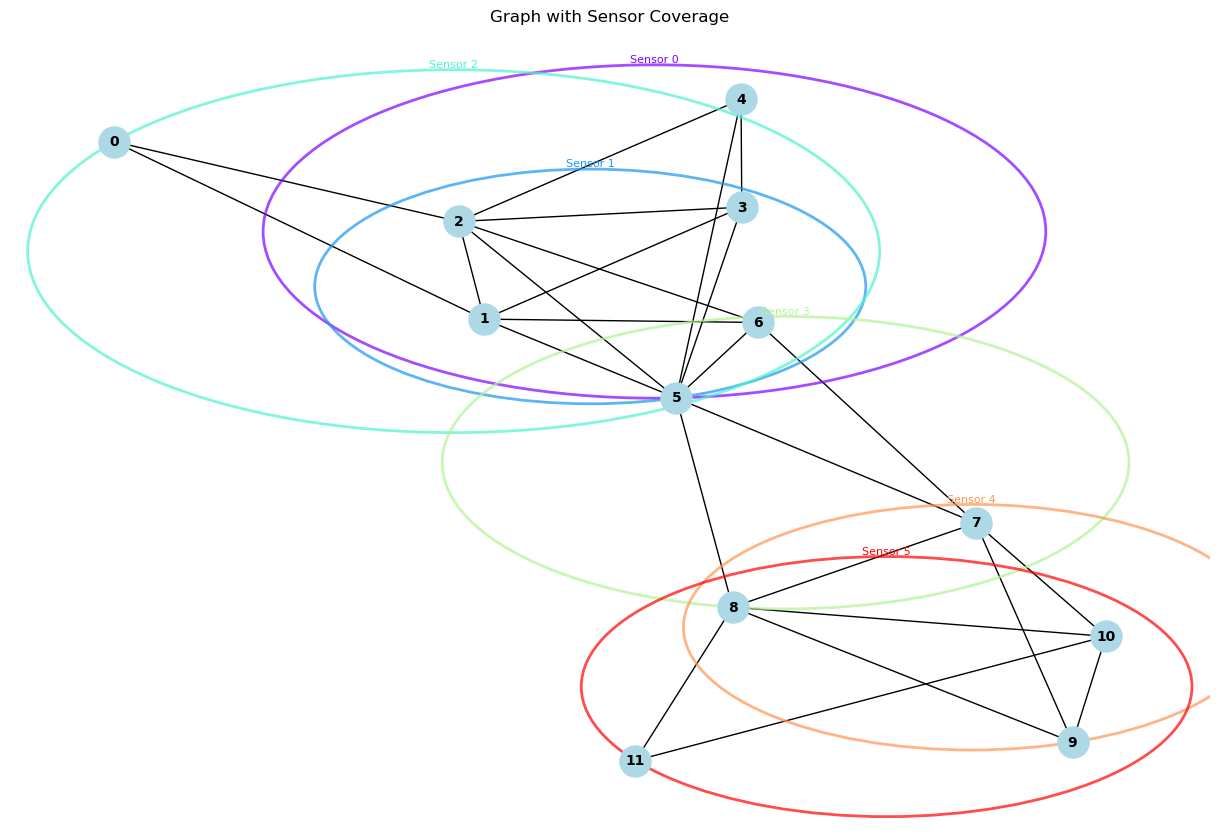

In [754]:
draw_graph_with_sensors(Gp, S)

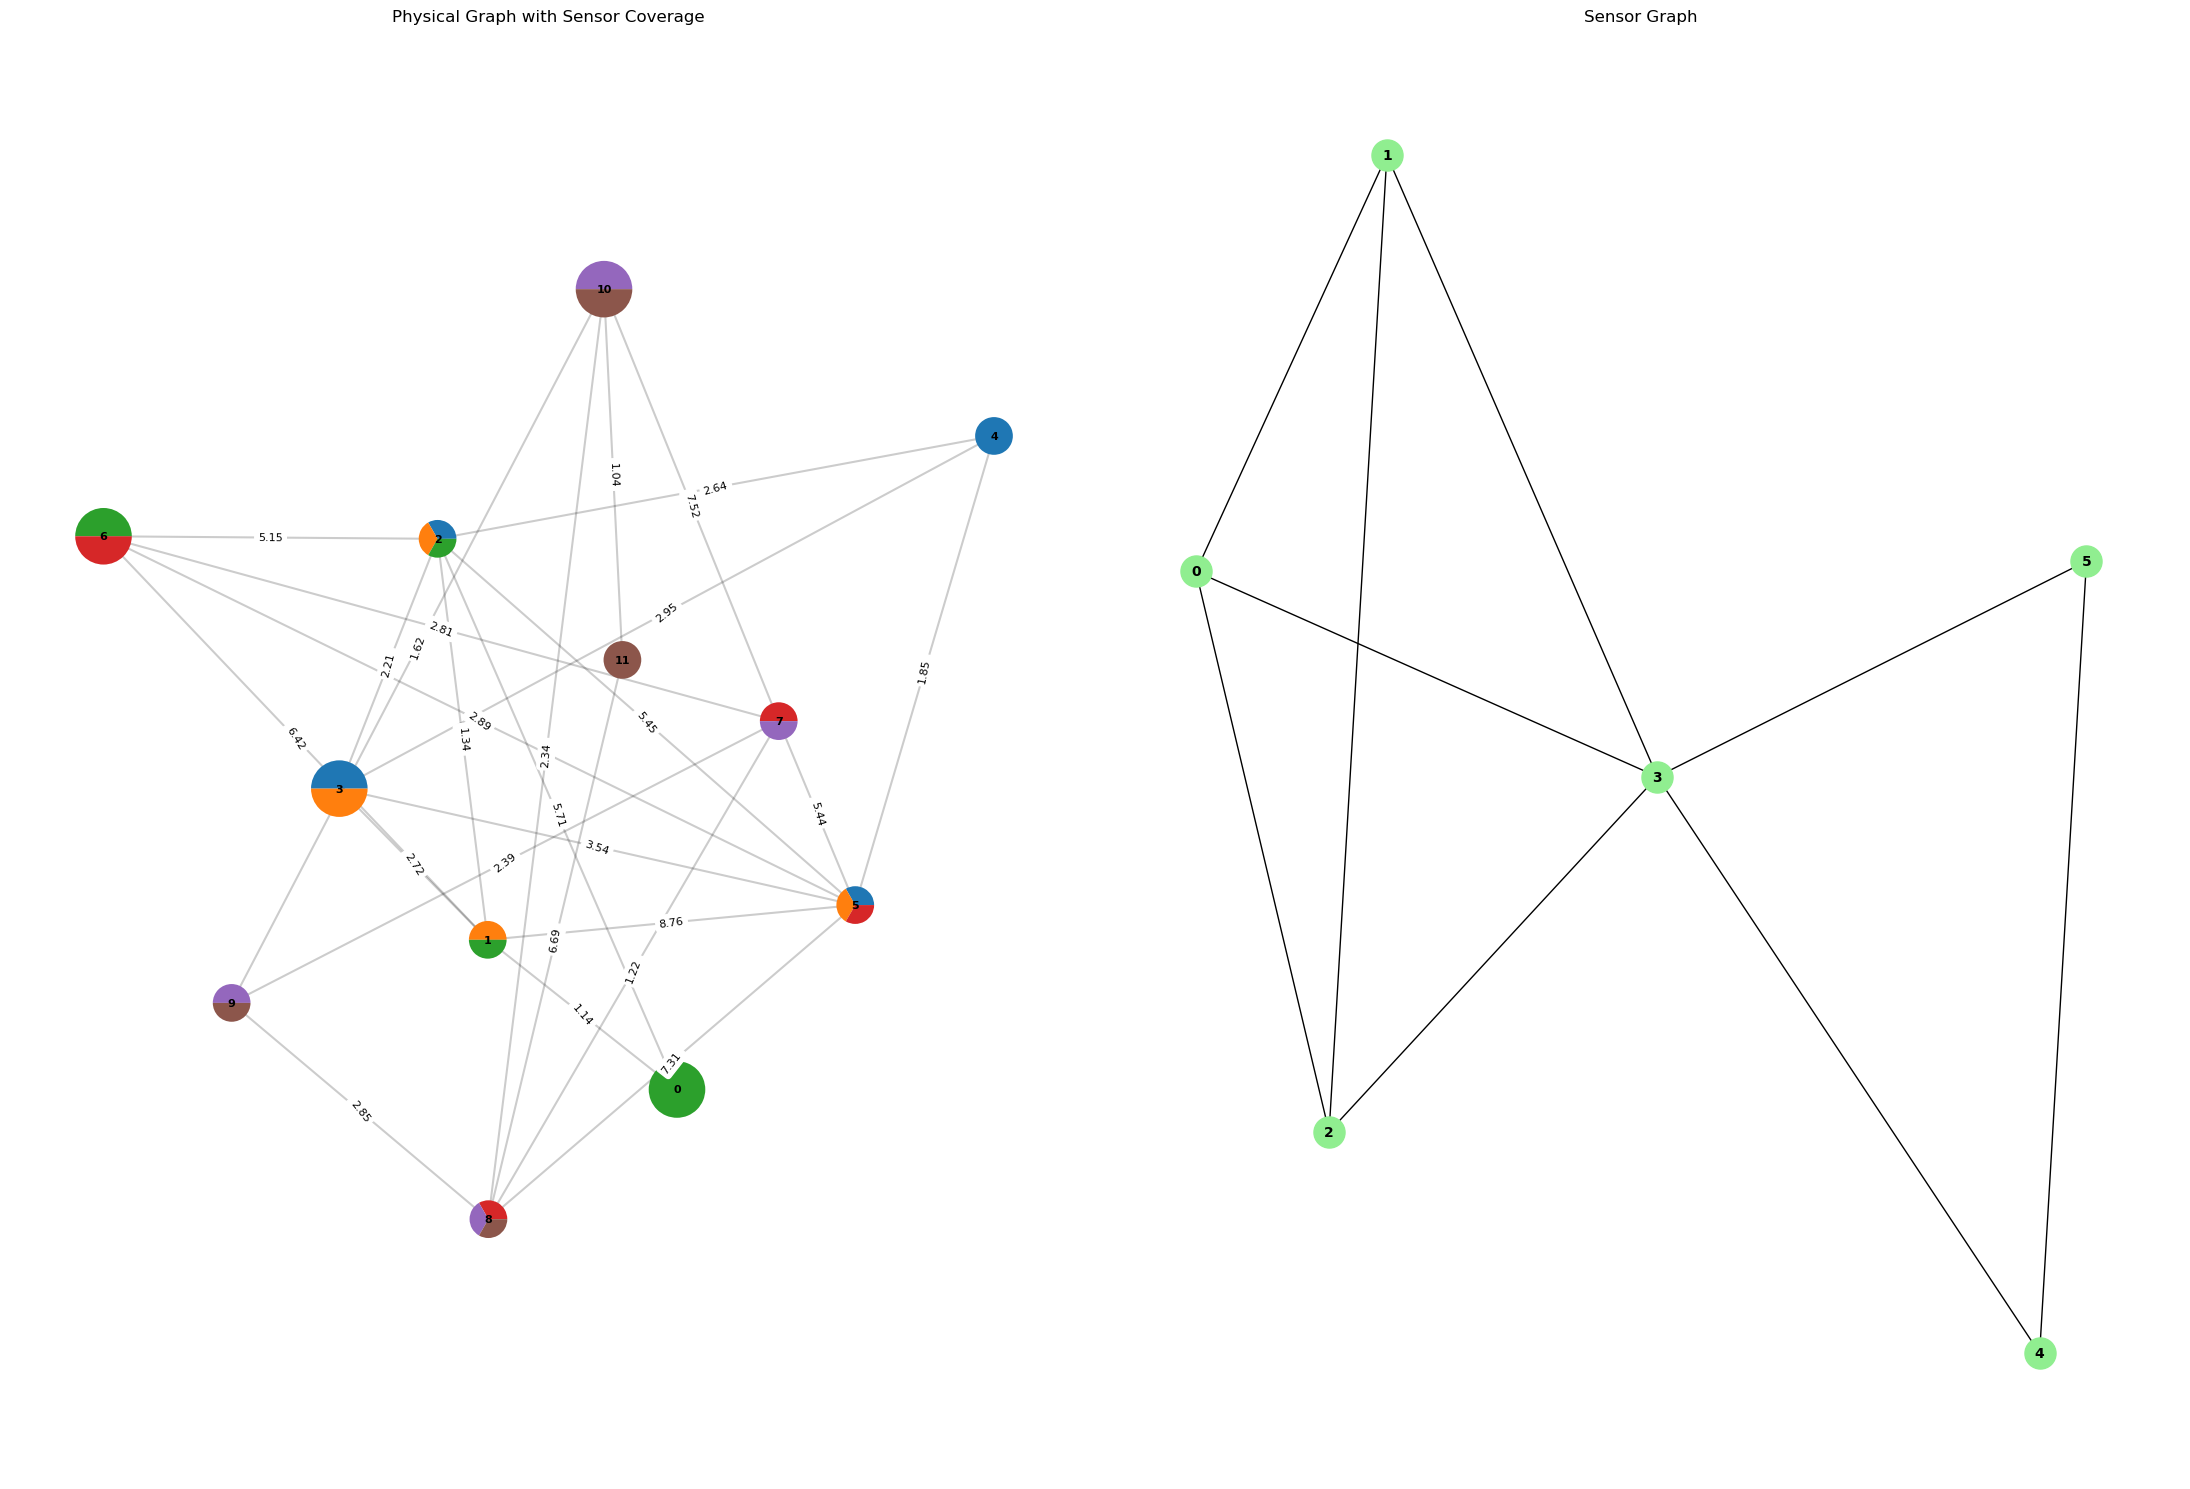

In [755]:
draw_graphs(Gp,Gs, C, S, pos)

In [808]:
path_length_weight=1
number_of_sensors_weight=1
physical_path_deception_weight=10
sensor_path_deception_weight=10
weights=[path_length_weight,number_of_sensors_weight,physical_path_deception_weight,sensor_path_deception_weight]

Path metric for LDP path: 0.8148976524477526
LDP node path: [0, 1, 2, 4, 5, 7, 8, 10] Path weight: 15.969999999999999 Number of sensors: 4
LDP sensor path [2, 0, 3, 5]


C:\Users\yaweh\AppData\Local\Temp\ipykernel_48096\3974539854.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


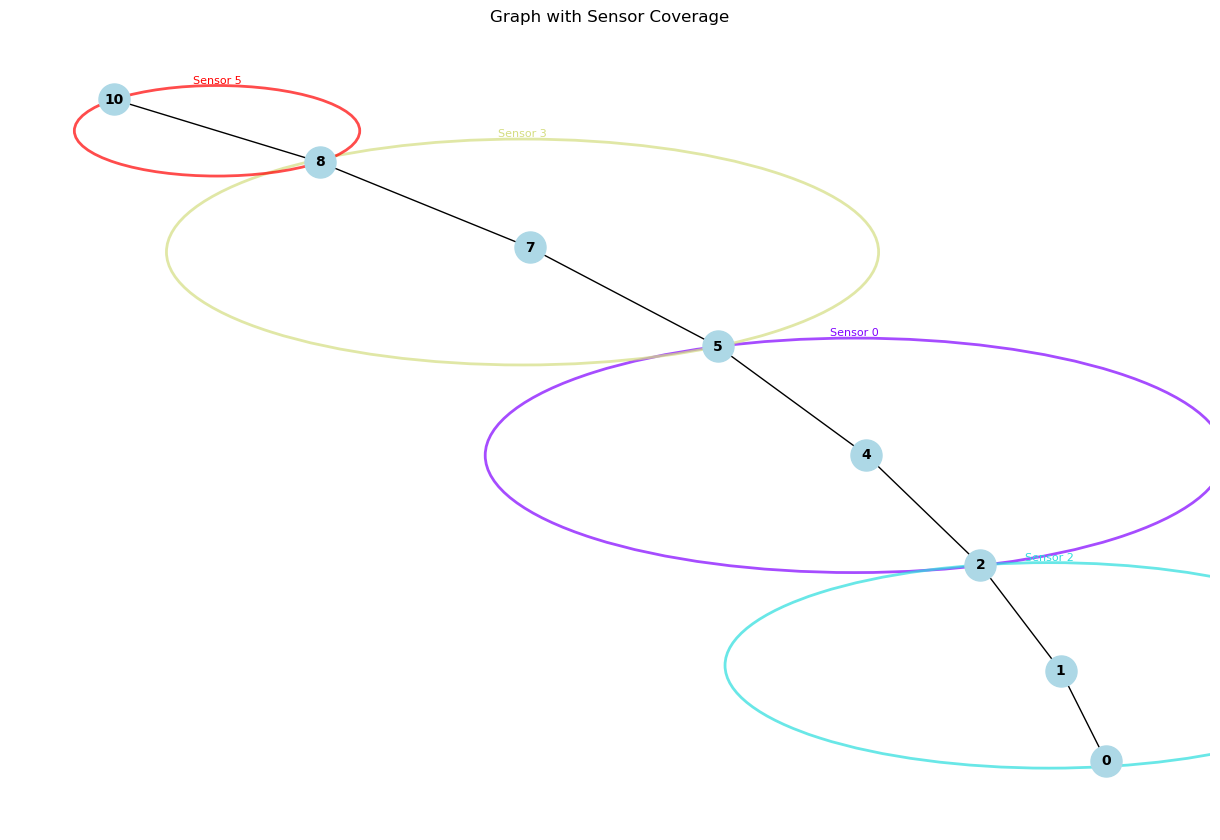

In [757]:
path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node ,percent_truthful_sensor,complete_path,complete_sensor_path=best_physical_path_strategy_(Gp,0,Gs,S,target_start,Se,C)
path_metric=evaluate_path_and_sensor(Gp,path_weight,complete_path,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node,percent_truthful_sensor,weights)
print('Path metric for LDP path:',path_metric)
print('LDP node path:',complete_path,'Path weight:',path_weight,'Number of sensors:',number_of_sensors)
print('LDP sensor path',complete_sensor_path)
path_subgraph=nx.path_graph(complete_path)
adjusted_mapping={}
for sensor,mapping in S.items():
    if sensor in complete_sensor_path:
        new_map=set()
        for node in mapping:
            if node in complete_path:
                new_map.add(node)
        adjusted_mapping[sensor]=new_map
        
draw_graph_with_sensors(path_subgraph, adjusted_mapping)

Path metric for direct path: 3.221875 Deceptiveness 1.0
Direct node path: [0, 1, 2, 4, 5, 7, 10] Path weight: 19.93 Number of sensors: 4
Direct sensor path [2, 0, 3, 4]


C:\Users\yaweh\AppData\Local\Temp\ipykernel_48096\3974539854.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


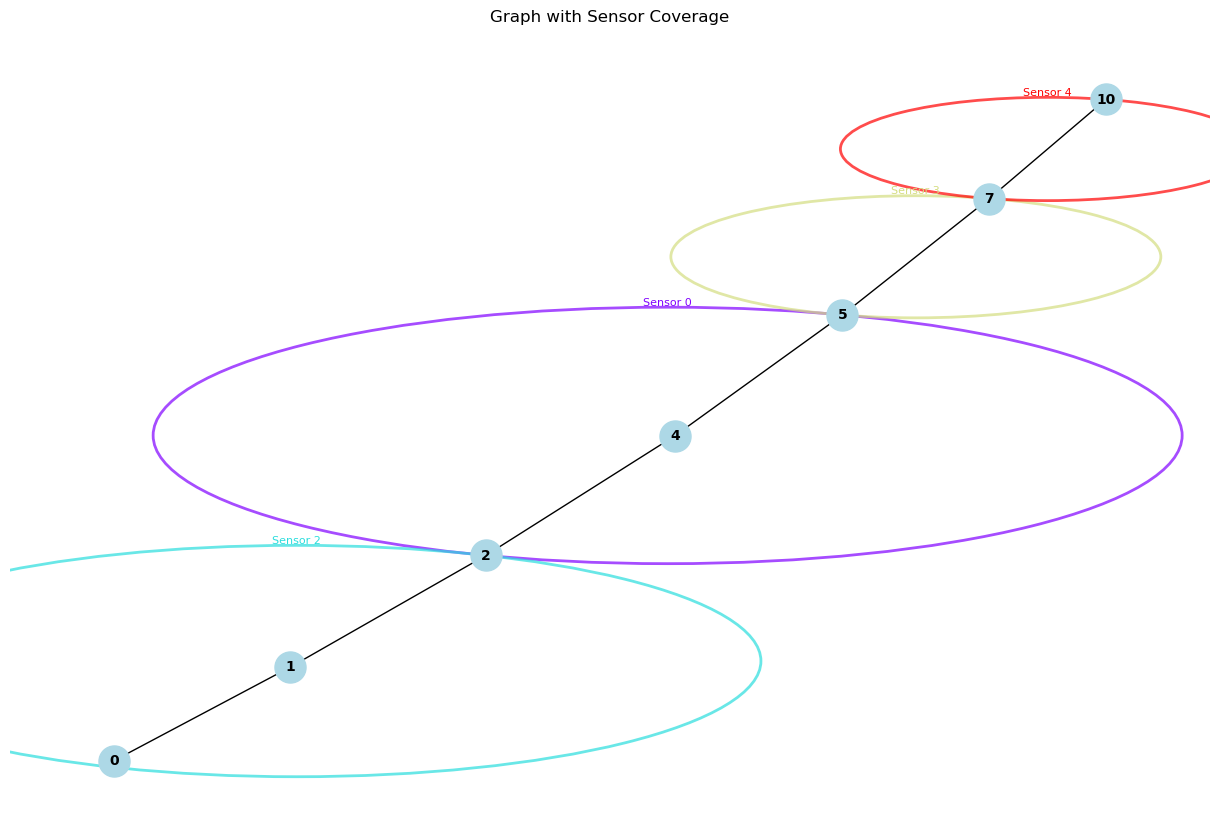

In [860]:
path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node ,percent_truthful_sensor,complete_path,complete_sensor_path=best_physical_path_strategy_no_ldp(Gp,0,Gs,S,target_start,Se,C)
path_metric=evaluate_path_and_sensor(Gp,path_weight,complete_path,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node,percent_truthful_sensor,weights)
print('Path metric for direct path:',path_metric,'Deceptiveness',1-percent_truthful_node)
print('Direct node path:',complete_path,'Path weight:',path_weight,'Number of sensors:',number_of_sensors)
print('Direct sensor path',complete_sensor_path)
path_subgraph=nx.path_graph(complete_path)
adjusted_mapping={}
for sensor,mapping in S.items():
    if sensor in complete_sensor_path:
        new_map=set()
        for node in mapping:
            if node in complete_path:
                new_map.add(node)
        adjusted_mapping[sensor]=new_map
        
draw_graph_with_sensors(path_subgraph, adjusted_mapping)

[2, 3, 5]
{(0, 1), (9, 10), (1, 2), (10, 11), (5, 8), (8, 10), (5, 7), (6, 7), (0, 2), (8, 9), (2, 6), (5, 6), (8, 11), (1, 6), (7, 8)}
[0, 1, 6, 5, 8, 10]
returned
Path metric for sensor optimized path: 3.7654166666666664 Deceptiveness 0.4
Sensor optimized node path: [0, 1, 6, 5, 8, 10] Path weight: 20.099999999999998 Number of sensors: 3
Optimized sensor path [2, 3, 5]


C:\Users\yaweh\AppData\Local\Temp\ipykernel_48096\3974539854.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


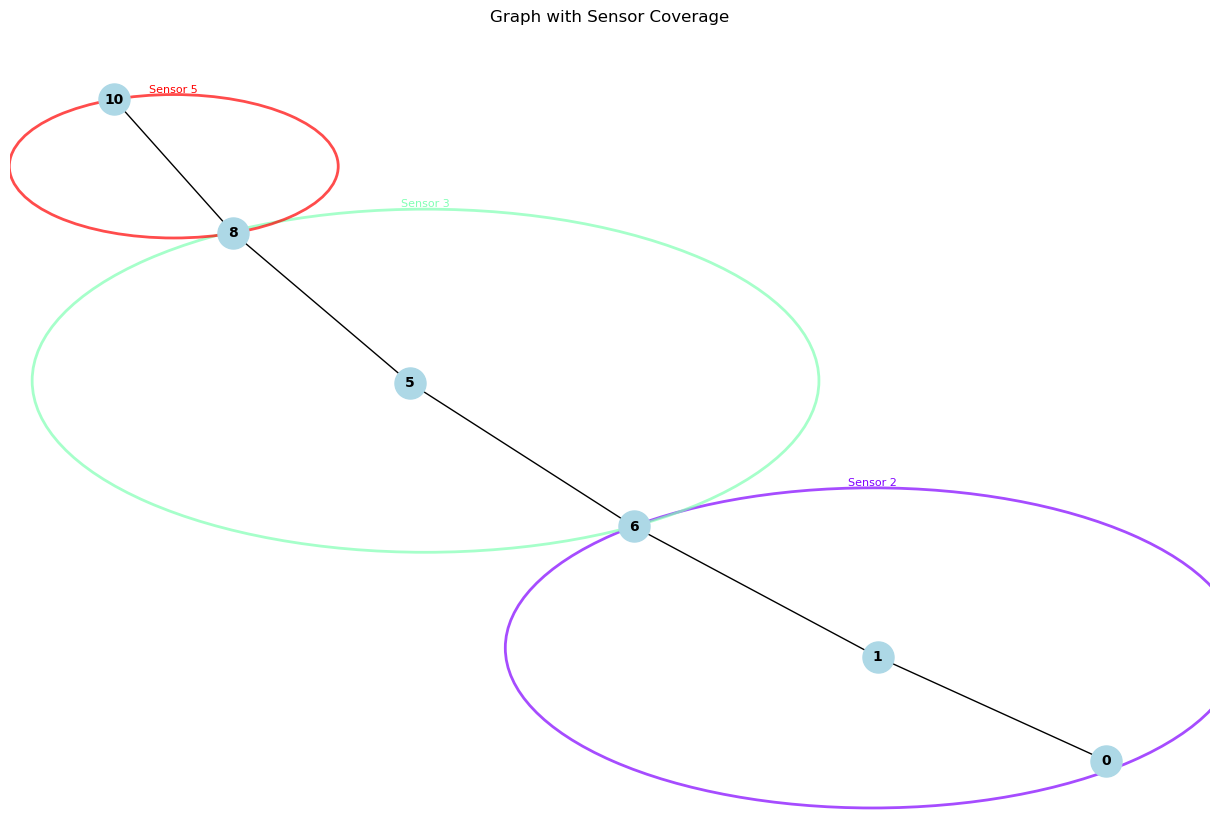

In [869]:
path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node ,percent_truthful_sensor,complete_path,complete_sensor_path=best_sensor_path_strategy(Gp,Gs,0,S,Se,target_start,C)
path_metric=evaluate_path_and_sensor(Gp,path_weight,complete_path,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node,percent_truthful_sensor,weights)
print('Path metric for sensor optimized path:',path_metric,'Deceptiveness',percent_truthful_node)
print('Sensor optimized node path:',complete_path,'Path weight:',path_weight,'Number of sensors:',number_of_sensors)
print('Optimized sensor path',complete_sensor_path)
path_subgraph=nx.path_graph(complete_path)
adjusted_mapping={}
for sensor,mapping in S.items():
    if sensor in complete_sensor_path:
        new_map=set()
        for node in mapping:
            if node in complete_path:
                new_map.add(node)
        adjusted_mapping[sensor]=new_map
        
draw_graph_with_sensors(path_subgraph, adjusted_mapping)

In [843]:
path_length_weight=1
number_of_sensors_weight=2
physical_path_deception_weight=2
sensor_path_deception_weight=1
weights=[path_length_weight,number_of_sensors_weight,physical_path_deception_weight,sensor_path_deception_weight]

In [870]:
brute_force_path_strategy(Gp,0,Gs,S,Se,target_start,C,weights,False)

78it [00:00, 7284.37it/s]


(2.7118055555555554, [0, 1, 2, 5, 7, 10], [2, 1, 3, 4])

In [873]:
start_node=0
end_node=target_start
shortest_distance, shortest_path,node_probabilities = shortest_path_dynamic(Gp, Gs,start_node, end_node,S,Se, custom_distance,weights)
fin_sensor_path,to_be_removed_sensors,sensor_and_coverage=best_sensors_for_path(shortest_path,start_node, Se, node_probabilities, S, targets, end_node,C,end_node)
if shortest_path:
    print(f"Shortest path from {start_node} to {end_node}: {shortest_path}","Sensor path:",fin_sensor_path)
else:
    print(f"No path exists between {start_node} and {end_node}")

Shortest path from 0 to 10: [0, 1, 2, 5, 7, 10] Sensor path: [2, 0, 3, 4]


C:\Users\yaweh\AppData\Local\Temp\ipykernel_48096\3974539854.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


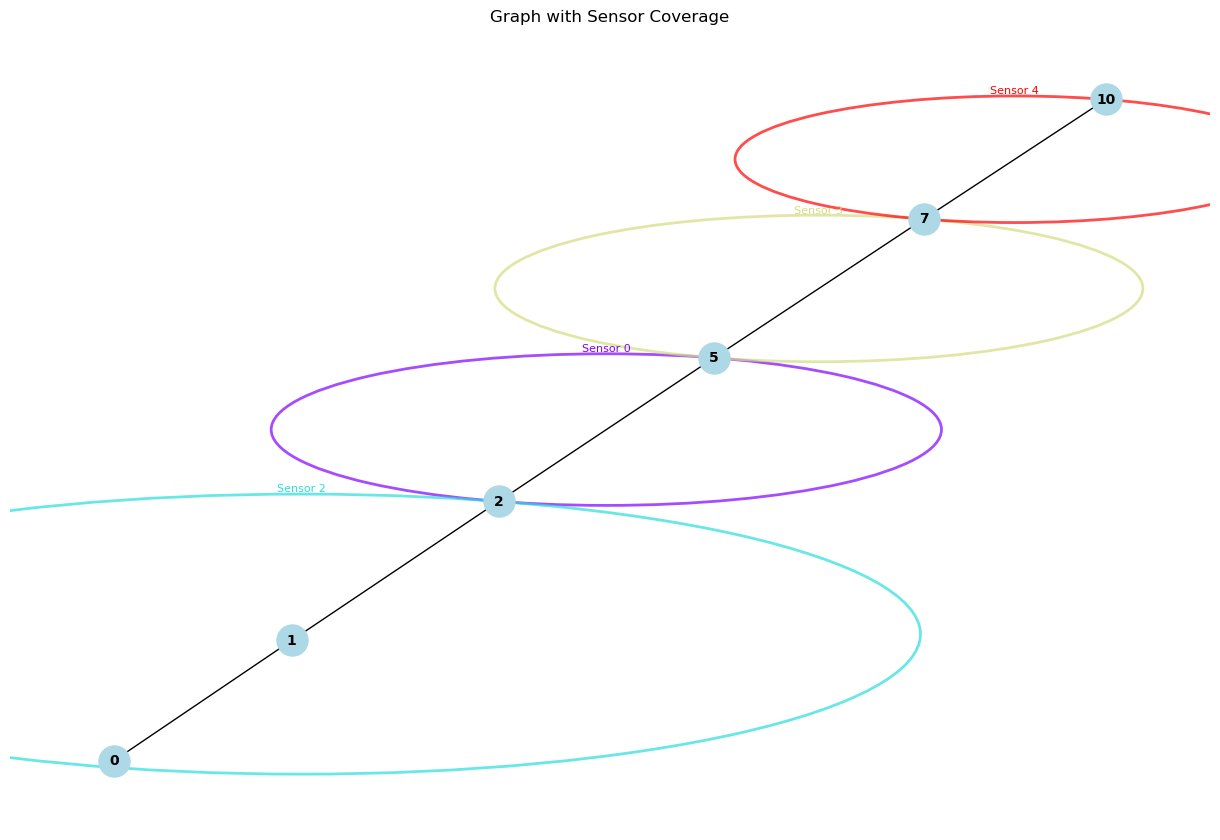

In [876]:
path_subgraph=nx.path_graph(shortest_path)
adjusted_mapping={}
for sensor,mapping in S.items():
    if sensor in fin_sensor_path:
        new_map=set()
        for node in mapping:
            if node in shortest_path:
                new_map.add(node)
        adjusted_mapping[sensor]=new_map
        
draw_graph_with_sensors(path_subgraph, adjusted_mapping)

In [858]:
fin_sensor_path

[2, 0, 3, 4]